# Hyperparameter Importance - Protoype 1
First of all, we need to select our flow (or algorithm) and benchmark suite (a collection of ML tasks).
This is done using their IDs, which can be found on the OpenML website.
We can also set a minimum amount of runs per task required to use the results from said task.

In [2]:
import fanova as fnv
import openml as oml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ConfigSpace.hyperparameters.hp_components import ROUND_PLACES

# Settings
flow_id = 6969
suite_id = 99
min_runs = 500

## Fetching OpenML data
To fetch the data from OpenML, we first retrieve the tasks contained in the benchmark suite.
In order to get the raw data, we retrieve all evaluations of the flow on a given task, retrieve related setups, and join them.
Finally, we preprocess the data by isolating the hyperparameters and accuracy values.

In [3]:
tasks = oml.study.get_suite(suite_id=suite_id).tasks

def get_data(task):
    # First we check if there are even enough runs with this fast function
    evals = oml.evaluations.list_evaluations(function='predictive_accuracy',
                                             tasks=[task],
                                             flows=[flow_id],
                                             output_format='dataframe')
    if len(evals) < min_runs:
        return None
    ids = evals.setup_id.drop_duplicates().values
    tot = len(ids)

    # Then we collect the associated setups with this slow function
    # In batches, because URLs otherwise become too long
    batches = []
    offset = 0
    batch_size = 250
    while offset < tot:
        batch = oml.setups.list_setups(setup=ids[offset:(offset+batch_size)],
                                       output_format='dataframe').parameters
        batches.append(batch)
        offset += batch_size

    # Then we match the evaluations with the setups
    params = pd.concat(batches)
    data = evals.join(params, on='setup_id')

    return data

def process_params(params):
    # Extract the relevant information
    params = params.map((lambda p_list: {p['parameter_name']: p['value'] for p in p_list.values()}))
    params = pd.json_normalize(params)

    # Remove constant columns
    params = params[params.columns[params.nunique() > 1]]

    # Split params into numerical and categorical for preprocessing
    p_num = params.map(pd.to_numeric, errors="coerce", downcast="float")
    p_num = p_num[p_num.columns[p_num.nunique() > 1]]
    p_cat = params.drop(p_num.columns, axis=1)

    # Fill in missing features
    # TODO: this should not be necessary. Maybe issue warning / discard entry instead?
    # Categorical features: most common category
    p_cat = p_cat.fillna(p_cat.mode(axis=0).iloc[0])
    # Numerical features: median
    p_num = p_num.fillna(p_num.median(axis=0))

    # Categorical features are one-hot encoded
    # TODO: actually we should be creating a ConfigSpace with categorical params
    p_cat = pd.get_dummies(p_cat, dtype=float)

    # Merge params
    params = p_num.join(p_cat)

    # If we do not give fANOVA an explicit ConfigSpace, we need to
    # round the data, as it will otherwise infer bounds, round those,
    # and complain that the unrounded data is out of bounds.
    # TODO: possibly not necessary if we use config_spaces
    params = params.apply(np.round, decimals=ROUND_PLACES, axis=1)

    return params

## Evaluating fANOVA
Now we can use these functions to retrieve OpenML data per task, and apply fANOVA.

In [4]:
# Dict containing fANOVA results
results = {}

# Variables for debug printing
num = 1
tot = len(tasks)

# Get data and compute fANOVA scores per task
for task in tasks:
    print(f'Task {task} ({num}/{tot})')
    num += 1

    # We continue if there were not enough data points
    data = get_data(task)
    if data is None:
        continue

    # Extract the relevant data
    X = process_params(data.parameters)
    Y = data.value.to_numpy()

    # Fit the fanova model
    f = fnv.fANOVA(X, Y)

    # Extract the marginal variances
    # TODO: perhaps also pairwise?
    index = 0
    result = {}
    for param in X.columns.values:
        result[param] = f.quantify_importance((index,))[(index,)]['individual importance']
        print(f'- {param}: {result[param]}')
        index += 1

    # Save the result
    results[task] = result

Task 3 (1/72)
- max_features: 0.047639947427951794
- min_samples_leaf: 0.8250859251006586
- min_samples_split: 0.0003786511630007695
- random_state: 7.061407277995536e-05
- bootstrap_false: 0.022268894182360624
- bootstrap_true: 0.0134313285392718
- criterion_"entropy": 0.0003134073677489284
- criterion_"gini": 0.00015456506305626784
- strategy_"mean": 4.506780809631064e-06
- strategy_"median": 3.967852722059405e-06
- strategy_"most_frequent": 2.121972841150641e-06
- sparse_false: 2.4533734820814704e-06
- sparse_true: 3.2854636564608452e-06
Task 6 (2/72)
- max_features: 0.21740933500029214
- min_samples_leaf: 0.667209627958389
- min_samples_split: 0.003022123928060173
- random_state: 0.00015073246494131482
- bootstrap_false: 0.020934787479790325
- bootstrap_true: 0.013435842986220005
- criterion_"entropy": 1.628641813230476e-05
- criterion_"gini": 1.4700251424984986e-05
- strategy_"mean": 3.0168859887692858e-06
- strategy_"median": 1.950606080156517e-06
- strategy_"most_frequent": 1.27

We can also easily export the results in csv format.

In [5]:
file_name = f'results-f{flow_id}-s{suite_id}.csv'
df = pd.DataFrame.from_dict(results, orient='index')
df.to_csv(file_name, index=False)

Or alternatively, we can plot the results in a violinplot.

/home/rogier/inf3/swe/p312_swe/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2383: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


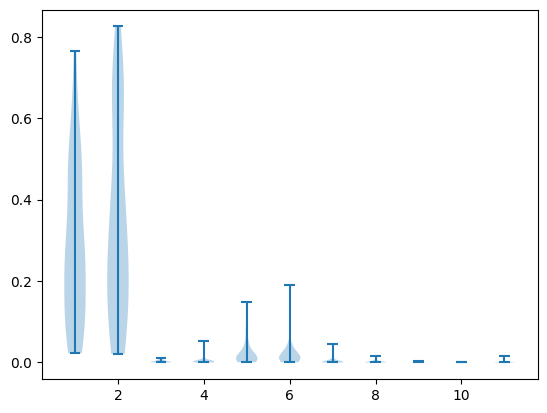

In [6]:
df = pd.DataFrame.from_dict(results, orient='index')
plt.violinplot(df)
plt.show()